# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
from sklearn import linear_model as lm
import scikitplot as skplt
pd.options.mode.chained_assignment = None  # default='warn'

# helper functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [5]:
def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [6]:
def performace(model_name,data,y_val,yhat_class,k):
    import sklearn.metrics
    prec = sklearn.metrics.precision_score(y_val,yhat_class)
    recal = sklearn.metrics.recall_score(y_val,yhat_class)
    recal_k = recall_at_k(data,k)
    prec_k = precision_at_k(data,k)
    
    return pd.DataFrame({'Model Name':model_name,
                        'Precison':prec,
                        'Recall':recal,
                        'k':k,
                        'Precison at k':prec_k,
                        'Recall at k':recal_k},index=[0])

In [7]:
def performace_cross_val(data,target,model,model_name,round_n=3,splits=4,shuffle_n=True,random=42,k=2000):
    
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits,shuffle=shuffle_n,random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target,'id'])
    precision = []
    recall = []
    prec_k = []
    rec_k = []
    for train_index, test_index in skf.split(X,y):
        #train the model 
        model.fit(X.iloc[train_index],y.iloc[train_index])

        #predict the classification 
        yhat_class = model.predict( X.iloc[test_index] )

        #predict the probabilit
        yhat_proba = model.predict_proba(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index],yhat_class)
        rec = sklearn.metrics.recall_score(y.iloc[test_index],yhat_class)
        precision.append(prec)
        recall.append(rec)

        # sort the test dataframe by the probabiliti score of the model
        aux = X.iloc[test_index]
        aux[target] = y.iloc[test_index]
        aux['score'] = yhat_proba[:,1].tolist()

        # sorte by score
        aux = aux.sort_values('score',ascending=False)

        # precision and recall at k
        prec_k.append(precision_at_k(aux,k))
        rec_k.append(recall_at_k(aux,k))

    # return a dataset with the metrics    
    return pd.DataFrame({'Model name': model_name + " Cross_Val",
                                'PRECISION CROSS_VAL': np.round( np.mean( precision ), round_n ),
                                'PRECISON STD': np.round( np.std( precision ), round_n ),
                                'RECALL CROSS_VAL': np.round( np.mean( recall ), round_n ),
                                'RECALL STD': np.round( np.std( recall ), round_n ),
                                'K': k,
                                'PRECISION AT K CROSS_VAL': np.round( np.mean( prec_k ), round_n ),
                                'PRECISION AT K STD': np.round( np.std( prec_k ), round_n ),
                                'RECALL AT K CROSS_VAL': np.round( np.mean( rec_k), round_n ),
                                'RECALL AT K STD': np.round( np.std( rec_k )) },index=[0]) 

# Load data

In [8]:
df6 = pd.read_csv('data/df5.csv')

In [9]:
df6.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response
0,1,0.369231,28.0,26.0,0,0.716263,3,1,1
1,2,0.861538,3.0,26.0,0,0.598616,2,0,0
2,3,0.415385,28.0,26.0,0,0.058824,3,1,1
3,4,0.015385,11.0,152.0,1,0.667820,1,0,0
4,5,0.138462,41.0,152.0,1,0.100346,1,0,0


In [10]:
df6.dtypes

id                        int64
age                     float64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
vintage                 float64
vehicle_age               int64
vehicle_damage            int64
response                  int64
dtype: object

## Slipt train test

In [11]:
train, val = train_test_split(df6,test_size=0.3,stratify=df6['response'],random_state=42)

# train dataframes
X_train = train.copy()
y_train = X_train['response']
X_train.drop(columns = ['response','id'],inplace=True)
# validation dataframes
x_val = val.copy()
y_val = val['response']
x_val.drop(columns = ['response','id'],inplace=True)

# Machine learning

## KNN

In [12]:
#model
knn_model = KNeighborsClassifier(n_neighbors=5)

# model training
knn_model.fit(X_train,y_train)

KNeighborsClassifier()

In [13]:
#model prediction proba - poder de generalizção
yhat_knn_proba = knn_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_knn_class = knn_model.predict( x_val )

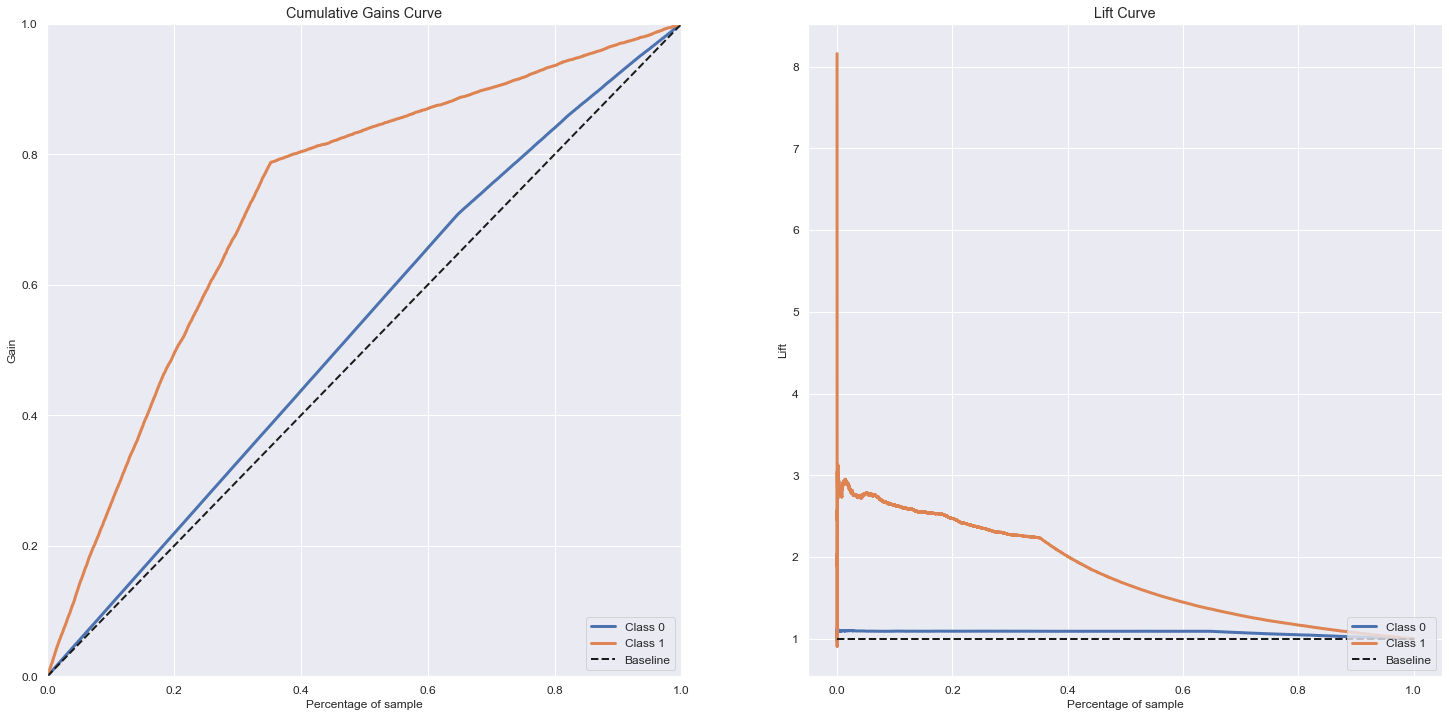

In [14]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_knn_proba,ax=ax[1]);

## Linear model

In [15]:
lm_model = lm.LogisticRegression(random_state=42,n_jobs=-1)
lm_model.fit(X_train,y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [16]:
#model prediction proba - poder de generalizção
yhat_lm_proba = lm_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_lm_class = lm_model.predict( x_val )

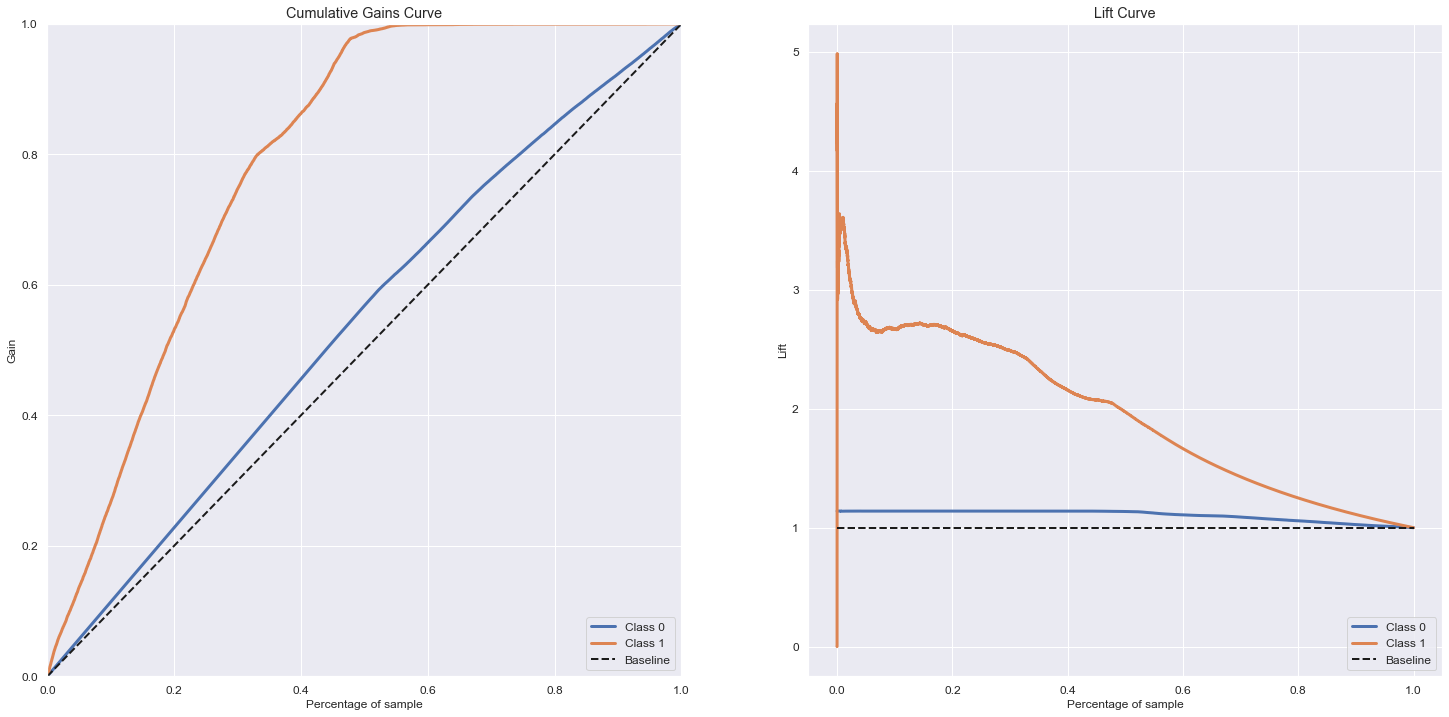

In [17]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_lm_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_lm_proba,ax=ax[1]);

## Random forrest classifier

In [18]:
rf_model = RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
rf_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [19]:
#model prediction proba - poder de generalizção
yhat_rf_proba = rf_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_rf_class = rf_model.predict( x_val )

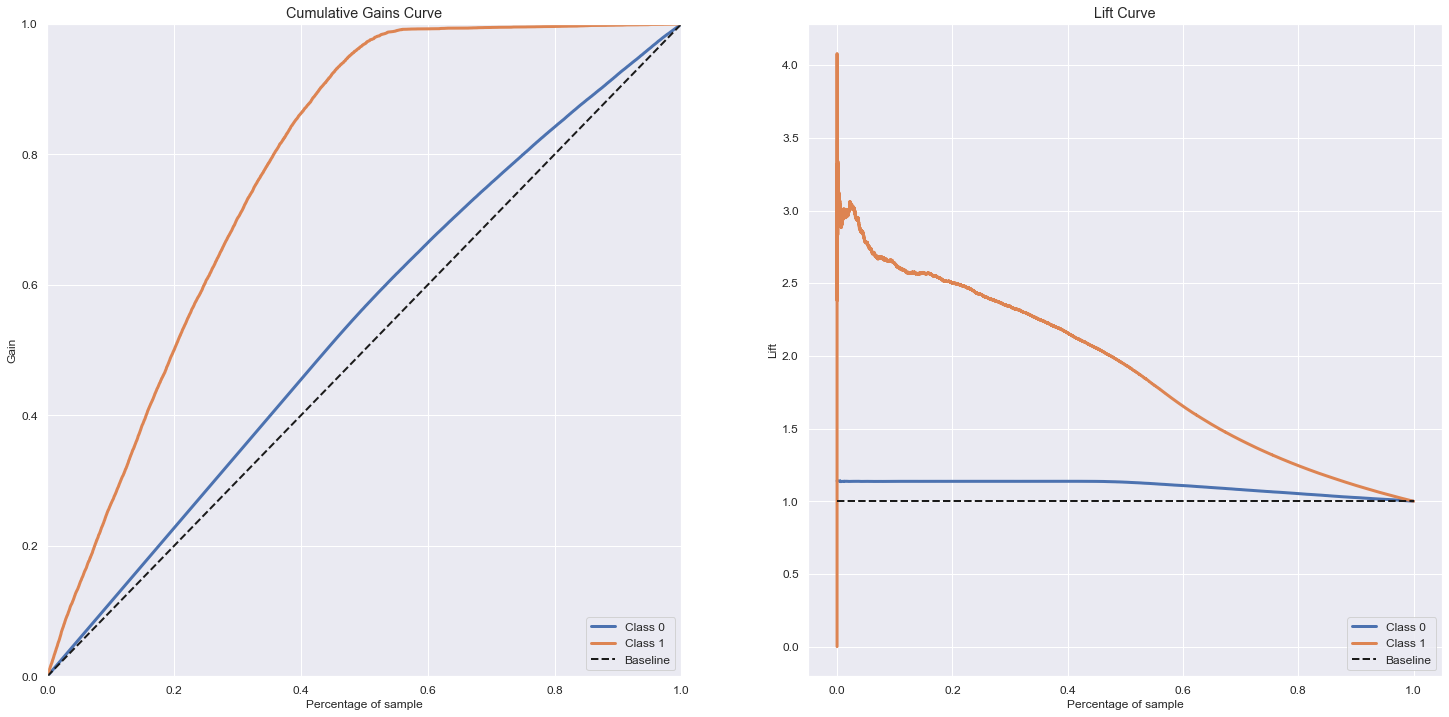

In [20]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_rf_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_rf_proba,ax=ax[1]);

## Extratree classifier

In [21]:
et_model = ExtraTreesClassifier(n_estimators=1000,random_state=42,n_jobs=-1,max_depth=10)
et_model.fit(X_train,y_train)

ExtraTreesClassifier(max_depth=10, n_estimators=1000, n_jobs=-1,
                     random_state=42)

In [22]:
#model prediction proba - poder de generalizção
yhat_et_proba = et_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_et_class = et_model.predict( x_val )

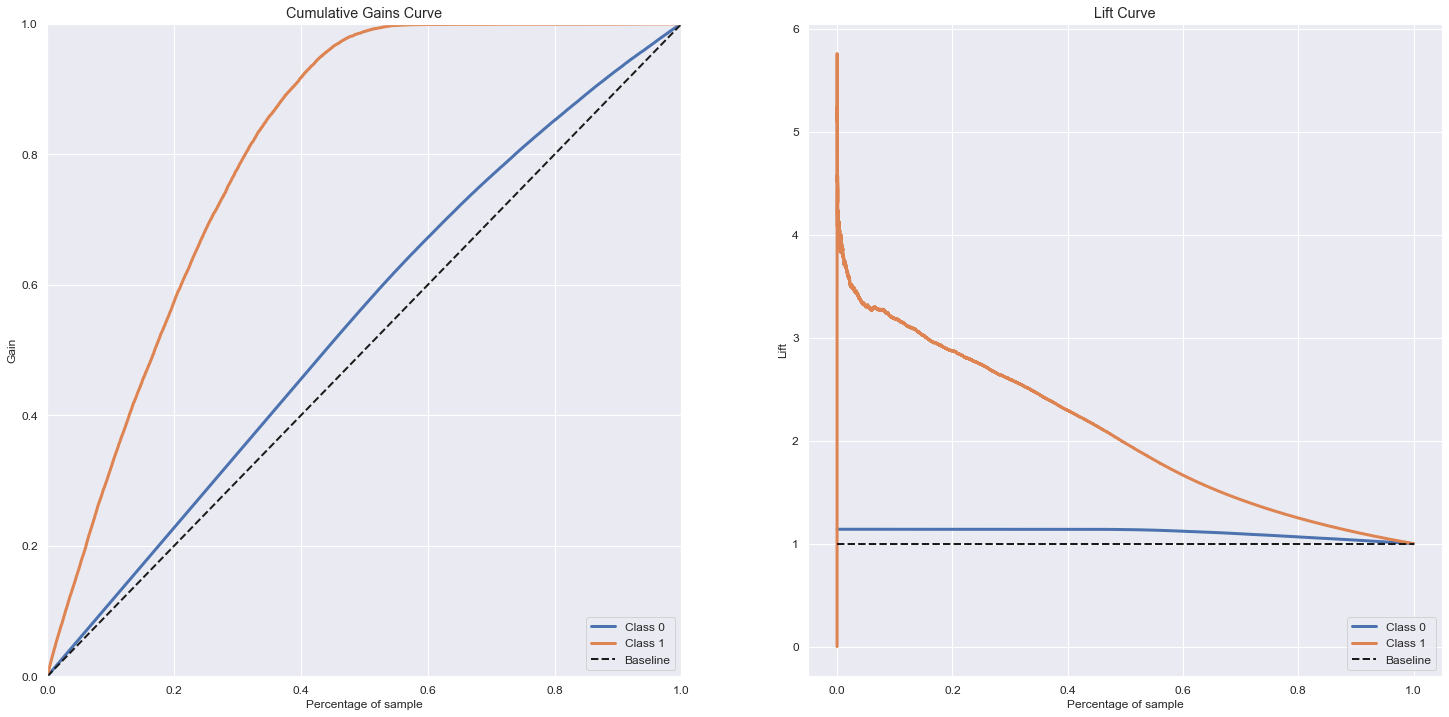

In [23]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_et_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_et_proba,ax=ax[1]);

## XGBoost

In [24]:
xgb_model = xgb.XGBClassifier(objective='reg:squarederror',
                             n_estimators=1000,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(X_train,y_train)

In [25]:
#model prediction proba - poder de generalizção
yhat_xgb_proba = xgb_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_xgb_class = xgb_model.predict( x_val )

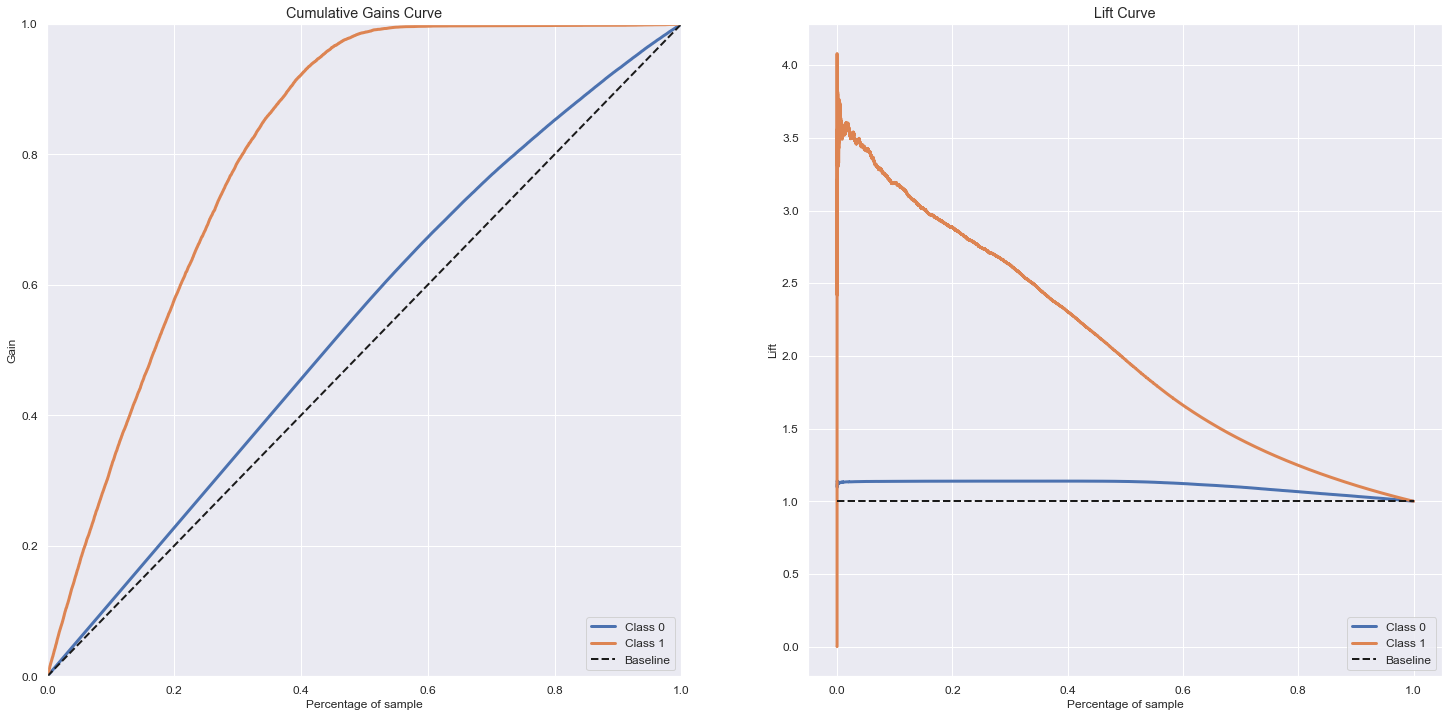

In [26]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_xgb_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_xgb_proba,ax=ax[1]);

# Model performace 

In [27]:
clients = 20000

## KNN

In [28]:
knn_df = val.copy()

In [29]:
knn_df['score_knn'] = yhat_knn_proba[:,1].tolist()
# sorte by score
knn_df = knn_df.sort_values('score_knn',ascending=False)

In [30]:
knn_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_knn
87582,87583,0.369231,28.0,26.0,0,0.968858,2,1,1,1.0
209375,209376,0.230769,47.0,124.0,0,0.685121,2,1,0,1.0
23137,23138,0.030769,10.0,26.0,0,0.844291,2,1,0,1.0
334075,334076,0.400000,43.0,155.0,0,0.048443,2,1,1,1.0
66585,66586,0.338462,12.0,26.0,0,0.038062,2,1,1,1.0


In [31]:
knn_performace = performace("KNN",knn_df,y_val,yhat_knn_class,clients)

In [32]:
knn_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,KNN,0.338387,0.178406,20000,0.309985,0.442446


## Linear model

In [33]:
lm_df = val.copy()

In [34]:
lm_df['score_lm'] = yhat_lm_proba[:,1].tolist()
# sorte by score
lm_df = lm_df.sort_values('score_lm',ascending=False)

In [35]:
lm_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_lm
205844,205845,0.169231,1.0,26.0,0,0.380623,3,1,0,0.538778
375383,375384,0.153846,9.0,31.0,0,0.782007,3,1,0,0.537737
334418,334419,0.184615,28.0,26.0,0,0.141869,3,1,0,0.531767
330638,330639,0.184615,28.0,26.0,0,0.432526,3,1,1,0.530637
91143,91144,0.184615,28.0,26.0,0,0.979239,3,1,0,0.528510


In [36]:
lm_performace = performace("linear model",lm_df,y_val,yhat_lm_class,clients)

In [37]:
lm_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,linear model,0.444444,0.001998,20000,0.331283,0.472847


## Randon forrest

In [38]:
rf_df = val.copy()

In [39]:
rf_df['score_rf'] = yhat_rf_proba[:,1].tolist()
# sorte by score
rf_df = rf_df.sort_values('score_rf',ascending=False)

In [40]:
rf_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_rf
106975,106976,0.153846,28.0,26.0,0,0.162630,1,1,0,0.997000
70894,70895,0.415385,28.0,26.0,0,0.550173,2,1,1,0.994091
223683,223684,0.369231,28.0,26.0,0,0.851211,2,1,0,0.994042
287179,287180,0.384615,28.0,26.0,0,0.653979,2,1,0,0.991699
72981,72982,0.384615,28.0,26.0,0,0.653979,2,1,0,0.991699


In [41]:
rf_performace = performace("Random forest",rf_df,y_val,yhat_rf_class,clients)

In [42]:
rf_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,Random forest,0.328247,0.207236,20000,0.311284,0.444302


## Extra trees

In [43]:
et_df = val.copy()

In [44]:
et_df['score_et'] = yhat_et_proba[:,1].tolist()
# sorte by score
et_df = et_df.sort_values('score_et',ascending=False)

In [45]:
et_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_et
198227,198228,0.769231,28.0,26.0,0,0.387543,1,1,0,0.528581
333801,333802,0.769231,28.0,26.0,0,0.598616,1,1,1,0.525305
282873,282874,0.538462,41.0,26.0,0,0.702422,1,1,0,0.492989
292587,292588,0.507692,28.0,26.0,0,0.719723,1,1,1,0.484059
15523,15524,0.553846,33.0,26.0,0,0.446367,1,1,1,0.482387


In [46]:
et_performace = performace("Extra trees",et_df,y_val,yhat_et_class,clients)

In [47]:
et_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,Extra trees,0.5,0.000071,20000,0.360032,0.51388


## XGboost

In [48]:
xgb_df = val.copy()

In [49]:
xgb_df['score_xgb'] = yhat_xgb_proba[:,1].tolist()
# sorte by score
xgb_df = xgb_df.sort_values('score_xgb',ascending=False)

In [50]:
xgb_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_xgb
308033,308034,0.446154,8.0,3.0,0,0.996540,2,1,0,0.833463
269431,269432,0.153846,3.0,163.0,0,0.975779,2,1,0,0.792653
359029,359030,0.584615,28.0,3.0,0,0.619377,3,1,0,0.786391
177941,177942,0.384615,28.0,124.0,0,0.307958,1,1,1,0.732223
61336,61337,0.461538,28.0,124.0,0,0.439446,1,1,1,0.723999


In [51]:
xgb_performace = performace("XGBoost",xgb_df,y_val,yhat_xgb_class,clients)

In [52]:
xgb_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,XGBoost,0.447059,0.021694,20000,0.360482,0.514522


# Model comparrison

In [53]:
model_comp = pd.concat([knn_performace,lm_performace,rf_performace,et_performace,xgb_performace])

In [54]:
model_comp.sort_values(by='Recall at k',ascending=False)

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,XGBoost,0.447059,0.021694,20000,0.360482,0.514522
0,Extra trees,0.500000,0.000071,20000,0.360032,0.513880
0,linear model,0.444444,0.001998,20000,0.331283,0.472847
0,Random forest,0.328247,0.207236,20000,0.311284,0.444302
0,KNN,0.338387,0.178406,20000,0.309985,0.442446


# Croos validation

In [55]:
models = {
    'KNN': knn_model,
    'Linear model': lm_model,
    'Random forrest': rf_model,
    'Extra trees': et_model,
    'XGBoost':xgb_model
}

In [56]:
models_comparison = pd.DataFrame()

In [57]:
for c, v in models.items():
    aux = performace_cross_val(df6,'response',v,c,k=20000)
    models_comparison = pd.concat([models_comparison,aux])

C:\Users\Lavin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lavin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
models_comparison.sort_values(by='RECALL AT K CROSS_VAL',ascending=False)

,Model name,PRECISION CROSS_VAL,PRECISON STD,RECALL CROSS_VAL,RECALL STD,K,PRECISION AT K CROSS_VAL,PRECISION AT K STD,RECALL AT K CROSS_VAL,RECALL AT K STD
0,XGBoost Cross_Val,0.451,0.022,0.021,0.003,20000,0.349,0.004,0.598,0.0
0,Extra trees Cross_Val,0.183,0.185,0.000,0.000,20000,0.347,0.003,0.594,0.0
0,Linear model Cross_Val,0.348,0.048,0.002,0.001,20000,0.319,0.003,0.547,0.0
0,Random forrest Cross_Val,0.324,0.001,0.205,0.001,20000,0.304,0.003,0.521,0.0
0,KNN Cross_Val,0.340,0.004,0.183,0.001,20000,0.301,0.002,0.515,0.0


In [62]:
models_comparison.to_csv('data/models_comparison.csv',index=False)